# Analytics for Unstructured Data: Group Assignment #1

### Authors: Luke Leon, Maxine Gardner, Kedar Godbole, Kimble Horsak, Sonali Hornick, Deeksha Koonadi

# Web Scaper Code

In [74]:
import requests
from bs4 import BeautifulSoup
import csv

#URL and list creation to add comments
base_url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans'
page_number = 1
comments_collected = []

while len(comments_collected) < 5000:
    response = requests.get(f'{base_url}/p{page_number}')
    soup = BeautifulSoup(response.text, 'html.parser')
    comments = soup.find_all('div', class_='Comment')  #Update this selector based on actual HTML

    # Break the loop if no comments are found (end of pages)
    if not comments:
        break
    
    for comment in comments:
        if len(comments_collected) >= 5000:
            break
        date_tag = comment.find('time')
        message_tag = comment.find(class_='Message')  # Adjust class to match actual content
        date = date_tag['datetime'] if date_tag else 'Unknown Date' #assignts date or unknown. 
        message = message_tag.get_text(strip=True) if message_tag else 'Unknown Comment'
        comments_collected.append([date, message])
    
    page_number += 1  # Increment page number

#add comments to csv file and save csv file
with open('scraper_output.csv', 'w', newline='', encoding='utf-8') as file: #special encoding to fix MAC/Windows compatibility issues
    writer = csv.writer(file)
    writer.writerow(['Date', 'Message'])  #headers
    writer.writerows(comments_collected) #adds list 

print("Data has been written to CSV file successfully. Total comments:", len(comments_collected))

Data has been written to CSV file successfully. Total comments: 5000


In [75]:
import csv
from collections import Counter
import re

# Step 1: Read the comments from the CSV
comments = []
with open('scraper_output.csv', 'r', newline='', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        comments.append(row['Message'])

# Step 2: Tokenize the text and count words
word_count = Counter()
for comment in comments:
    # Remove punctuation and split into words
    words = re.findall(r'\b\w+\b', comment.lower())  # This regex finds words and ignores punctuation.
    word_count.update(words)

# Step 3: Sort the words by count in descending order
sorted_words = sorted(word_count.items(), key=lambda item: item[1], reverse=True)

# Step 4: Write the sorted counts to a new CSV file
with open('word_counts_sorted.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Word', 'Count'])  # Write header
    for word, count in sorted_words:
        writer.writerow([word, count])
#print statements
print("Word counts have been written to word_counts_sorted.csv successfully, sorted by frequency.")

Word counts have been written to word_counts_sorted.csv successfully, sorted by frequency.


# TASK A 

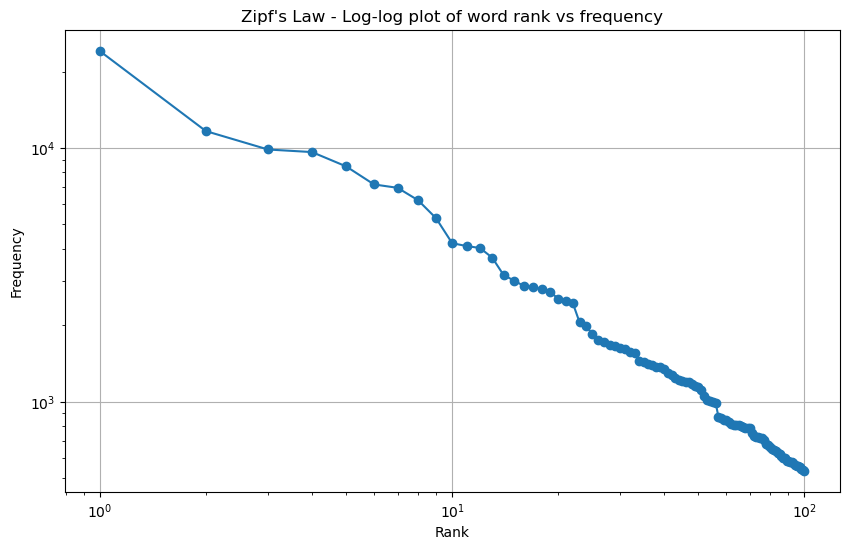

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.001e+04
Date:                Fri, 20 Sep 2024   Prob (F-statistic):          1.76e-100
Time:                        13:40:15   Log-Likelihood:                 110.56
No. Observations:                 100   AIC:                            -217.1
Df Residuals:                      98   BIC:                            -211.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.3740      0.033    315.508      0.0

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import statsmodels.api as sm
from scipy import stats  # Import scipy for the t-distribution

df = pd.read_csv('scraper_output.csv')

# Function to count words in text
def word_count(text):
    if isinstance(text, str):
        # splits text into words
        words = text.split()
        return Counter(words)
    return Counter()  # returns an empty counter for non-string values

# Apply word count on message column - converts to string and handles NaN
word_counts = Counter()
df['Message'].apply(lambda x: word_counts.update(word_count(str(x))))

# Get the most common 100 words
most_common_words = word_counts.most_common(100)
ranks = np.arange(1, 101)
frequencies = [count for word, count in most_common_words]

# Plot Zipf's Law
plt.figure(figsize=(10,6))
plt.loglog(ranks, frequencies, marker="o")
plt.title("Zipf's Law - Log-log plot of word rank vs frequency")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Prepare data for regression
log_ranks = np.log(ranks)
log_frequencies = np.log(frequencies)

# Add a constant term for intercept in the regression
X = sm.add_constant(log_ranks)
y = log_frequencies

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression model
print(results.summary())

# Extract the slope and intercept
slope = results.params[1]
intercept = results.params[0]

print(f"Slope of the log-log plot: {slope}")
print(f"Intercept of the log-log plot: {intercept}")

# Hypothesis test: Is the slope statistically different from -1?
# We are testing: H0: slope = -1, HA: slope ≠ -1
slope_std_error = results.bse[1]  # standard error of the slope
t_stat = (slope + 1) / slope_std_error  # t-statistic for testing if slope = -1

print(f"T-statistic for testing slope = -1: {t_stat}")

# Use scipy.stats for the t-distribution's cdf
p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=len(log_ranks) - 2))  # Two-tailed p-value

print(f"P-value for the test that slope = -1: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis. The slope is statistically different from -1.")
else:
    print("Fail to reject the null hypothesis. The slope is not statistically different from -1 (supports Zipf's law).")

As shown by the above regression, we can reject the null hypothesis and show that the slope is statistically different from -1. Therefore this data set does not support Zipf’s law econometrically.

# TASK B

In [80]:
import pandas as pd
from collections import Counter
import re

# Load the CSV files
df = pd.read_csv('scraper_output.csv')
brand_df = pd.read_csv('car_models_and_brands.csv')

# Drop columns with non-brand brands/models from Barua's file.
brands_drop = ['car', 'seat', 'problem', 'sedan']
brand_df_filter = brand_df[~brand_df['Brand'].isin(brands_drop)]

# Step 1: Create a dictionary that maps each car model to its brand
# Convert models to lowercase for case-insensitive matching
model_to_brand = {model.lower(): brand for brand, models in brand_df_filter.groupby('Brand')['Model'].apply(list).to_dict().items() for model in models}

# Create a set of valid brands for filtering the output
valid_brands = set(brand_df_filter['Brand'].str.lower())

# Step 2: Define a normalization mapping for synonymous brands
# Add 'mercedes' to map to 'mercedes-benz'
brand_normalization = {
    'mercedes-benz': 'mercedes',
}

# Step 3: Define a function to replace car models with brands in a message
def replace_model_with_brand(text):
    """
    Takes a text message, replaces car models with their corresponding brands,
    and returns the set of unique brands mentioned in the message.
    """
    if isinstance(text, str):
        # Convert to lowercase and split the text into words
        words = re.findall(r'\b\w+\b', text.lower())
        # Use a set to avoid duplicate brand mentions in the same message
        unique_words_in_message = set()
        
        for word in words:
            # If the word is a car model, replace it with the corresponding brand
            if word in model_to_brand:
                brand = model_to_brand[word]
            else:
                brand = word
            
            # Normalize the brand name if it's in the normalization mapping
            if brand in brand_normalization:
                brand = brand_normalization[brand]
            
            # Add the brand (normalized or not) to the set
            unique_words_in_message.add(brand)
        
        return unique_words_in_message
    return set()

# Step 4: Count the frequency of each brand in all messages
brand_counts = Counter()

# Apply the function to each message in the 'Message' column and update the brand count
df['Message'].apply(lambda x: brand_counts.update(replace_model_with_brand(str(x))))

# Filter the brand_counts to include only the valid brands (after normalization)
filtered_brand_counts = Counter({brand: count for brand, count in brand_counts.items() if brand in valid_brands or brand in brand_normalization.values()})

# Step 5: Get the top 10 brands by frequency 
top_10_brands = filtered_brand_counts.most_common(10)

# Print the results
print("Top 10 brands by frequency:")
for brand, count in top_10_brands:
    print(f"{brand}: {count} mentions")


Top 10 brands by frequency:
bmw: 1347 mentions
acura: 572 mentions
honda: 456 mentions
audi: 438 mentions
infiniti: 401 mentions
toyota: 329 mentions
nissan: 316 mentions
subaru: 212 mentions
mercedes: 176 mentions
volkswagen: 162 mentions


# TASK C

In [82]:
import pandas as pd
import numpy as np
from collections import Counter
import re

# Load the CSV files
df = pd.read_csv('scraper_output.csv')
brand_df = pd.read_csv('car_models_and_brands.csv')

# Drop columns with non-brand brands/models from Barua file.
brands_drop = ['car', 'seat', 'problem', 'sedan']
brand_df_filter = brand_df[~brand_df['Brand'].isin(brands_drop)]

# Step 1: Create a dictionary that maps each car model to its brand
# Convert models to lowercase for case-insensitive matching
model_to_brand = {model.lower(): brand for brand, models in brand_df_filter.groupby('Brand')['Model'].apply(list).to_dict().items() for model in models}

# Create a set of valid brands for filtering the output
valid_brands = set(brand_df_filter['Brand'].str.lower())

# Step 2: Define a normalization mapping for synonymous brands
# Add 'mercedes-benz' to map to 'mercedes'
brand_normalization = {
    'mercedes-benz': 'mercedes',
    # Add more normalization pairs if needed
}

# Updated replace_model_with_brand function
def replace_model_with_brand(text):
    """
    Takes a text message, replaces car models with their corresponding brands,
    normalizes the brand names, and records their positions.
    Returns a dictionary where the keys are brands and the values are lists of word positions.
    """
    if isinstance(text, str):
        text = text.lower()
        words = re.findall(r'\b\w+(?:-\w+)*\b', text)  # Split into words using regex
        brands_in_message = {}

        for i, word in enumerate(words):
            # Replace models with brands
            if word in model_to_brand:
                brand = model_to_brand[word]
            else:
                brand = word

            # Normalize the brand name if it's in the normalization mapping
            if brand in brand_normalization:
                brand = brand_normalization[brand]

            # Add to brands_in_message if it's a valid brand
            if brand in valid_brands:
                if brand not in brands_in_message:
                    brands_in_message[brand] = []
                brands_in_message[brand].append(i)  # Record the word position
        
        return brands_in_message
    return {}

# Step 3: Replace models with brands in the 'Message' column
df['Brands_Positions'] = df['Message'].apply(replace_model_with_brand)

# Step 4: Count the frequency of each brand in all messages
# Collect all unique brands for each message, ignoring positions
df['Brands'] = df['Brands_Positions'].apply(lambda brand_dict: set(brand_dict.keys()))

# Count the frequency of each brand
brand_counts = Counter()
df['Brands'].apply(brand_counts.update)

# Step 5: Get the top 10 brands by frequency
top_10_brands = brand_counts.most_common(10)
top_10_brand_list = [brand for brand, _ in top_10_brands]

print("\nTop 10 brands by frequency:")
for brand, count in top_10_brands:
    print(f"{brand}: {count} mentions")

# Step 6: Calculate the co-occurrence of brands for lift analysis
num_docs = len(df)
lift_ratios = {}

brands = [brand.lower() for brand in top_10_brand_list]  # Ensure the top brands are lowercased for consistency

print(f"\nTotal number of documents (reviews): {num_docs}")
print("\nCalculating lift values between top 10 brands...\n")

def brands_within_distance(brand_a_positions, brand_b_positions, max_distance=7):
    """
    Check if any positions of brand_a and brand_b are within the specified max_distance.
    """
    for pos_a in brand_a_positions:
        for pos_b in brand_b_positions:
            if abs(pos_a - pos_b) <= max_distance:
                return True
    return False

for i, brand_a in enumerate(brands):
    for j, brand_b in enumerate(brands):
        if i < j:  # Compute for distinct brand pairs
            # Calculate the actual co-occurrence count (number of reviews mentioning both brands within max_distance words)
            actual_co_occurrences = df['Brands_Positions'].apply(
                lambda brand_dict: brand_a in brand_dict and brand_b in brand_dict and 
                brands_within_distance(brand_dict[brand_a], brand_dict[brand_b], max_distance=7)  # Using max_distance=7 as specified
            ).sum()

            # Get individual brand counts
            count_a = df['Brands'].apply(lambda x: brand_a in x).sum()
            count_b = df['Brands'].apply(lambda x: brand_b in x).sum()

            # Calculate probabilities
            p_a = count_a / num_docs
            p_b = count_b / num_docs
            p_ab = actual_co_occurrences / num_docs

            # Calculate lift if valid probabilities
            if p_a > 0 and p_b > 0 and p_ab > 0:
                lift = p_ab / (p_a * p_b)
                lift_ratios[(brand_a, brand_b)] = lift
                #print(f"Lift between {brand_a} and {brand_b}: {lift}")
            else:
                print(f"Skipping lift calculation for {brand_a} & {brand_b} due to zero probabilities.")

# Step 7: Create the lift matrix
print("\nCreating lift matrix...")
lift_matrix = pd.DataFrame(index=brands, columns=brands)

for (brand_a, brand_b), lift_value in lift_ratios.items():
    lift_matrix.at[brand_a, brand_b] = lift_value
    lift_matrix.at[brand_b, brand_a] = lift_value  # Since the matrix is symmetric

# Fill diagonal with 1 (lift between the same brand and itself is 1)
for brand in brands:
    lift_matrix.at[brand, brand] = 1.0

print("\nLift Matrix:")
print(lift_matrix)



Top 10 brands by frequency:
bmw: 1408 mentions
acura: 572 mentions
honda: 448 mentions
audi: 438 mentions
infiniti: 400 mentions
toyota: 328 mentions
nissan: 315 mentions
mercedes: 213 mentions
subaru: 211 mentions
volkswagen: 159 mentions

Total number of documents (reviews): 5000

Calculating lift values between top 10 brands...

Skipping lift calculation for mercedes & subaru due to zero probabilities.

Creating lift matrix...

Lift Matrix:
                 bmw     acura     honda      audi  infiniti    toyota  \
bmw              1.0  0.471829  0.190239  0.859407  0.790128  0.270666   
acura       0.471829       1.0  1.170704  0.758374  1.660839  0.239852   
honda       0.190239  1.170704       1.0  0.178368  0.334821  3.096418   
audi        0.859407  0.758374  0.178368       1.0  0.941781  0.208821   
infiniti    0.790128  1.660839  0.334821  0.941781       1.0  0.190549   
toyota      0.270666  0.239852  3.096418  0.208821  0.190549       1.0   
nissan      0.180375     0.444  1

# TASK D


Lift matrix saved to lift_matrix.csv

Preparing distance matrix for MDS...
Distance matrix prepared. Checking for NaN or infinite values:

Applying MDS...
MDS successful!

Plotting the MDS results...


C:\Users\krgod\AppData\Local\Temp\ipykernel_12500\3704141774.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  distance_matrix = 1 / lift_matrix.replace([0, np.nan], np.inf)


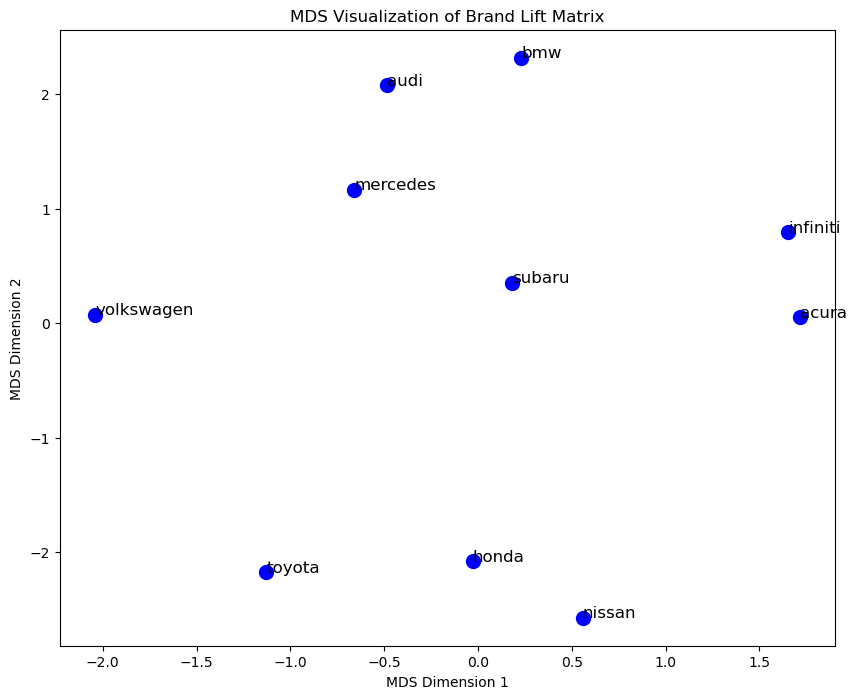

In [84]:
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Step 8: Save the lift matrix to CSV
csv_file_path = 'lift_matrix.csv'  # Modify the path as needed, e.g., 'C:/Users/Kimble/Downloads/lift_matrix.csv'
lift_matrix.to_csv(csv_file_path)
print(f"\nLift matrix saved to {csv_file_path}")

# Step 9: Prepare the distance matrix for MDS
print("\nPreparing distance matrix for MDS...")
# Replace zeros and NaNs with large values (infinity) to avoid division by zero
distance_matrix = 1 / lift_matrix.replace([0, np.nan], np.inf)

# Ensure diagonal elements are set to 0 since the distance to itself should be zero
np.fill_diagonal(distance_matrix.values, 0)

print("Distance matrix prepared. Checking for NaN or infinite values:")
if np.any(np.isnan(distance_matrix.values)):
    print("Error: Distance matrix contains NaN values.")
    raise ValueError("NaN values found in distance matrix.")
if np.any(np.isinf(distance_matrix.values)):
    print("Warning: Distance matrix contains infinite values.")

# Step 10: Apply MDS to the distance matrix
print("\nApplying MDS...")
try:
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    mds_coordinates = mds.fit_transform(distance_matrix)
    print("MDS successful!")
except Exception as e:
    print(f"Error during MDS: {e}")
    raise

# Step 11: Create a DataFrame with the MDS coordinates
mds_df = pd.DataFrame(mds_coordinates, index=lift_matrix.index, columns=['X', 'Y'])

# Step 12: Plot the MDS results
plt.figure(figsize=(10, 8))
plt.scatter(mds_df['X'], mds_df['Y'], color='blue', s=100)

# Annotate each point with its corresponding label (brand)
for brand in mds_df.index:
    plt.text(mds_df.loc[brand, 'X'], mds_df.loc[brand, 'Y'], brand, fontsize=12)

plt.title('MDS Visualization of Brand Lift Matrix')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')

print("\nPlotting the MDS results...")
plt.show()


# TASK E

The Brand Lift Matrix displays the lift values between various automotive brands which represents the strength of the relationships between the brands according to the consumer reviews we gathered from Edmunds. Through creating a brand lift matrix we can assess which car brands are comparable to our specific vehicle and use the lift matrix data to create a differentiation strategy.


The MDS plot provides a spatial visualization of how closely related the various automotive brands are to each other based on dissimilarity or similarity levels. Specifically, the distance between the points is a measure of how dissimilar one point is to another point. Essentially, the closer the points the more similar, and the farther the more dissimilar.


Certain clusters of data start to form in the MDS plot. At the bottom of the plot, Honda, Nissan, and Toyota are relatively close together, and thus pretty similar in terms of customer perception. Likewise, towards the top of the plot Audi and BMW are close together signifying similarity between the two. Mercedes is also listed in the vicinity, but customers seem to associate BMW and Audi to be more similar to each other than Mercedes. Similarly, Infinity and Acura are clustered close together on the right side. 


One surprising insight from the MDS plot is that Subaru was closer mentioned to the luxury European and Japanese manufacturers. While Subaru didn't have any lift values that were extremely high, or associated with a car brand, the higher correlation with Infiniti, Acura, and Audi coupled with low lift association with Toyota but it right in the middle of the MDS plot. JP Power could use this information and mention Subaru as a viable option when discussing higher-end car brands, and Subaru can use this information to market themselves as a competitor to these brands. 


Another interesting insight is how Volkswagen is isolated from the rest of the car brands. Although Volkswagen and Audi have an extremely high lift value, that is to be expected since Volkswagen is the majority shareholder in Audi. Volkswagen's isolation on the plot could be a blessing or a curse. JD Power and Volkswagen can use this MDS plot and do some further research to see whether Volkswagen is simply a brand that has a loyal customer base, who's customers will continue to buy Volkswagens. On the flip side, they could find that customers aren't talking about Volkswagen when they are discussing these cars, which means that it would be harder for Volkswagen to get customers of other car brands to switch over to them. 


We can make many insights based on the lift values and the MDS plot. We can make such comparisons with the rest of the points in the MDS graph and this would help car brands and JD Power understand how these brands are positioned and perceived in the market relative to each other. We can use this to understand how car brands stand in the market and use that information to develop insights and recommendations on how to strategically improve market share of our car. We can use the MDS plot to find the cars most similar to ours and find ways to implement competitive advantages or better market our car to differentiate and increase sales so we compete well against competitors. Using the data from the MDS plot, car brands have a better idea of who they are comparing against and can make products/marketing plans to directly compete with their nearest neighbors. JD Power can also take advantage of the insights to group these clusters of cars together in articles to increase reader engagement and ultimately boost JD Power's web traffic and profile. 

# TASK F

In [87]:
import csv
import re
import string
from collections import defaultdict
import pandas as pd
from nltk.corpus import stopwords
import nltk

# Download and set up stopwords from the NLTK package if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Global variables and data structures
lift_data = []  # To store lift values
word_frequency = defaultdict(int)  # Dictionary to store word frequency in posts
word_pair_frequency = defaultdict(lambda: defaultdict(int))  # Nested dictionary for word pair co-occurrences

# Load the CSV files
brand_df = pd.read_csv('car_models_and_brands.csv')
brands_drop = ['car', 'seat', 'problem', 'sedan']
brand_df_filter = brand_df[~brand_df['Brand'].isin(brands_drop)]

# Step 1: Create a dictionary that maps each car model to its brand
# Convert models to lowercase for case-insensitive matching
model_to_brand = {model.lower(): brand for brand, models in brand_df_filter.groupby('Brand')['Model'].apply(list).to_dict().items() for model in models}

# Create a set of valid brands for filtering the output
valid_brands = set(brand_df_filter['Brand'].str.lower())

# Step 2: Define a normalization mapping for synonymous brands
# Add 'mercedes-benz' to map to 'mercedes'
brand_normalization = {
    'mercedes-benz': 'mercedes',
    # Add more normalization pairs if needed
}

# Use the top 10 brands from the previous task
brands = [brand.lower() for brand in top_10_brand_list]
attributes = ['performance', 'luxury', 'handling', 'power', 'reliability']

# File paths
input_file = 'scraper_output.csv'  # Input data file
output_lift_values = 'Lift_Values_Brand_Attributes.csv'  # Output file for lift values
output_lift_matrix = 'Lift_Matrix_Brand_Attributes.csv'  # Output file for lift matrix

# Function to replace models with brands, normalize, and tokenize text
def replace_model_with_brand(text):
    """
    Takes a text message, replaces car models with their corresponding brands,
    normalizes the brand names, and records their positions.
    Returns a list of processed words in the message.
    """
    if isinstance(text, str):
        text = text.lower()
        words = re.findall(r'\b\w+(?:-\w+)*\b', text)  # Split into words using regex
        processed_words = []

        for i, word in enumerate(words):
            # Replace models with brands
            if word in model_to_brand:
                brand = model_to_brand[word]
            else:
                brand = word
            
            # Normalize the brand name if it's in the normalization mapping
            if brand in brand_normalization:
                brand = brand_normalization[brand]

            # Add the brand (normalized or not) to the list if it's a valid brand or an attribute
            if brand in valid_brands or brand in attributes:
                processed_words.append((brand, i))  # Keep the word and its position

        return processed_words
    return []

# Step 2: Process the input CSV file to extract posts and clean the text
def process_input_file(input_filename):
    """
    Processes the input CSV file to extract and clean posts.
    Returns a list of tokenized, cleaned posts.
    """
    posts = []
    
    with open(input_filename, 'r', encoding='utf-8') as f: #fixes some Windows/MAC compatibility
        reader = csv.reader(f)
        for row in reader:
            message = row[1]  # Assuming the post content is in the second column
            processed_words = replace_model_with_brand(message)
            posts.append(processed_words)
    
    return posts

# Step 3: Calculate word frequencies and word pair co-occurrences within a 7-word window
def calculate_frequencies(posts, max_distance=7):
    """
    Calculates the frequency of individual words (brands and attributes) and word pairs within a given word window.
    Updates the global word_frequency and word_pair_frequency dictionaries.
    """
    global word_frequency, word_pair_frequency
    
    for post in posts:
        # Track which brands and attributes have already been counted for this post
        counted_brands = set()
        counted_attributes = set()
        
        # Collect words and positions
        words_in_post = [word for word, _ in post]

        # Calculate individual word frequencies (counted once per post)
        for word in words_in_post:
            if word in brands:
                counted_brands.add(word)
            elif word in attributes:
                counted_attributes.add(word)
        
        # Update word frequencies for unique brands and attributes in the post
        for brand in counted_brands:
            word_frequency[brand] += 1
        for attribute in counted_attributes:
            word_frequency[attribute] += 1
        
        # Calculate co-occurrences within the specified word window
        for i, (word1, pos1) in enumerate(post):
            # Check if word1 is a brand
            if word1 in brands:
                # Check the next words within the max_distance
                for j in range(i + 1, len(post)):
                    word2, pos2 = post[j]
                    # Check if word2 is an attribute and within the max_distance
                    if word2 in attributes and abs(pos1 - pos2) <= max_distance:
                        word_pair_frequency[word1][word2] += 1
                        break  # Count each pair at most once per valid window

# Step 4: Calculate the lift between brand and attribute pairs
def calculate_lift():
    """
    Calculates the lift between brand-attribute pairs using the formula:
    Lift(brand, attribute) = N * #(brand, attribute) / (#(brand) * #(attribute)).
    """
    global lift_data
    
    total_posts = len(posts)  #Total posts
    
    for brand in brands:
        for attribute in attributes:
            # Get co-occurrence count
            co_occurrence = word_pair_frequency[brand][attribute]
            
            # Get counts for brand and attribute
            count_brand = word_frequency[brand]
            count_attribute = word_frequency[attribute]
            
            # Calculate lift using the provided formula
            if count_brand > 0 and count_attribute > 0:
                lift_value = (total_posts * co_occurrence) / (count_brand * count_attribute)
                # Store in the list
                lift_data.append({'brand': brand, 'attribute': attribute, 'lift_value': lift_value})

# Step 5: Add to csv file. 
def save_results():
    """
    Writes the calculated lift values to a CSV file and also generates a lift matrix,
    saving it to another CSV.
    """
    # Create DataFrame from lift_data
    df_lift = pd.DataFrame(lift_data)
    
    # Save lift values
    df_lift.to_csv(output_lift_values, index=False)
    
    # Generate and save lift matrix
    lift_matrix = df_lift.pivot(index='brand', columns='attribute', values='lift_value').fillna(0)
    lift_matrix.to_csv(output_lift_matrix)

# Main function to run the process
def main():
    # Step 1: Process the input file and extract posts
    global posts  # Make posts global so that it can be used in calculate_lift()
    posts = process_input_file(input_file)
    
    # Step 2: Calculate word frequencies and word pair co-occurrences within a 7-word window
    calculate_frequencies(posts, max_distance=7)  # Change max_distance if needed
    
    # Step 3: Calculate lift values
    calculate_lift()
    
    # Step 4: Save results
    save_results()

# Run the script
if __name__ == "__main__":
    main()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krgod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
#Following block returns the highest lift values from the created attributes file
lift_attr = pd.read_csv("Lift_Values_Brand_Attributes.csv")
max_lift_brands = lift_attr.loc[lift_attr.groupby('attribute')['lift_value'].idxmax()].reset_index(drop=True)
max_lift_brands

,brand,attribute,lift_value
0,bmw,handling,0.331029
1,subaru,luxury,0.879747
2,subaru,performance,0.461255
3,volkswagen,power,0.411686
4,audi,reliability,0.526976


# TASK G

JP Power and Associates (JDPA) is a company that is well-known for giving out awards and ranking consumer products. The advice I would give JDPA is to o take a look through the social media posts and attributes and try to align their awards/rankings based on what consumers are looking at. For example, from the dataset above, the 5 highest attributes were handling, luxury, performance, power, and reliability. JDPA could create an article titled "Brands with Best Handling" and rank car brands based on that attribute. Since handling is the most commonly mentioned attribute in the forums, it is likely that consumers would click and read on that article, which would increase web traffic and presence to JDPA. They could make similar articles for the other frequently mentioned attributes and/or make an article that summarizes the top brands for each of the attributes. This would cater to not only customers that want a broad overview with all major attributes in one article but also car enthusiasts that want to deep-dive into specific attributes. 

Another piece of advice I would give to my client would be to potentially run the analysis on social media posts over time and see how the attributes and lift values change. As technology and time goes by, there is further priority on different atttributes, so running this analysis every year or so and seeing the evolution in mentioned attributes would be valuable information not only to JDPA for their content creation, but also to the car companies, so that they can get better insight into what their consumers are talking about and adjust their production/advertising accordingly. 

# TASK H

In [91]:
import csv
import re
import string
import pandas as pd
from collections import defaultdict
from nltk.corpus import stopwords
import nltk

# Download and set up stopwords from the NLTK package if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load brands from the provided CSV file
brand_df = pd.read_csv('car_models_and_brands.csv')
brands_drop = ['car', 'seat', 'problem', 'sedan']
brand_df_filter = brand_df[~brand_df['Brand'].isin(brands_drop)]

# Step 1: Create a dictionary that maps each car model to its brand
# Convert models to lowercase for case-insensitive matching
model_to_brand = {model.lower(): brand for brand, models in brand_df_filter.groupby('Brand')['Model'].apply(list).to_dict().items() for model in models}

# Create a set of valid brands for filtering the output
valid_brands = set(brand_df_filter['Brand'].str.lower())

# Step 2: Define a normalization mapping for synonymous brands
# Add 'mercedes-benz' to map to 'mercedes'
brand_normalization = {
    'mercedes-benz': 'mercedes',
    # Add more normalization pairs if needed
}

# List of aspirational bigrams
aspirational_bigrams = [
    "would love", "dream of", "hope to", "would like", "wish for", 
    "look forward", "set sights", "want to", "long for", "aim to", "want a", "need a"
]

# File paths
input_file = 'scraper_output.csv'  # Input data file
output_lift_matrix = 'Lift_Matrix_Aspiration.csv'  # Output file for lift matrix

# Global variables and data structures
word_frequency = defaultdict(int)  # Dictionary to store word frequency in posts
word_pair_frequency = defaultdict(int)  # Dictionary for brand-aspiration co-occurrences

# Function to replace car models with brands, normalize, and replace aspirational bigrams
def replace_model_with_brand_and_aspiration(text):
    """
    Takes a text message, replaces car models with their corresponding brands,
    normalizes the brand names, and replaces aspirational bigrams with the word 'aspiration'.
    Returns a list of processed words in the message.
    """
    if isinstance(text, str):
        # Convert to lowercase and replace aspirational bigrams first
        text = text.lower()
        for bigram in aspirational_bigrams:
            text = re.sub(r'\b' + re.escape(bigram) + r'\b', 'aspiration', text)

        # Split into words using regex
        words = re.findall(r'\b\w+(?:-\w+)*\b', text)
        processed_words = []

        for i, word in enumerate(words):
            # Replace models with brands
            if word in model_to_brand:
                brand = model_to_brand[word]
            else:
                brand = word
            
            # Normalize the brand name if it's in the normalization mapping
            if brand in brand_normalization:
                brand = brand_normalization[brand]

            # Add the brand (normalized or not) or "aspiration" to the list if it's valid
            if brand in valid_brands or brand == 'aspiration':
                processed_words.append((brand, i))  # Keep the word and its position

        return processed_words
    return []

# Step 1: Process the input CSV file to extract posts, clean, replace models and aspirational bigrams
def process_input_file(input_filename):
    """
    Processes the input CSV file to extract and clean posts.
    Returns a list of tokenized, cleaned posts with aspirational bigrams and models replaced.
    """
    posts = []
    
    with open(input_filename, 'r', encoding='utf-8') as f: #Windows/MAC Compatibility
        reader = csv.reader(f)
        for row in reader:
            message = row[1]  # Assuming the post content is in the second column
            processed_words = replace_model_with_brand_and_aspiration(message)
            posts.append(processed_words)
    
    return posts

# Step 2: Calculate word frequencies and co-occurrences with "aspiration" within a specified window
def calculate_frequencies(posts, max_distance=7):
    """
    Calculates the frequency of individual brands and co-occurrences with "aspiration" within a given word window.
    Updates the global word_frequency and word_pair_frequency dictionaries.
    """
    global word_frequency, word_pair_frequency
    
    for post in posts:
        # Track which brands have already been counted for this post
        counted_brands = set()
        
        # Collect words and positions
        words_in_post = [word for word, _ in post]

        # Count individual brand frequencies (counted once per post)
        for word in words_in_post:
            if word in valid_brands:
                counted_brands.add(word)
        
        # Update word frequencies for unique brands in the post
        for brand in counted_brands:
            word_frequency[brand] += 1
        
        # Calculate co-occurrences within the specified word window
        for i, (word1, pos1) in enumerate(post):
            # Check if word1 is a brand
            if word1 in valid_brands:
                # Check the next words within the max_distance
                for j in range(i + 1, len(post)):
                    word2, pos2 = post[j]
                    # Check if word2 is 'aspiration' and within the max_distance
                    if word2 == 'aspiration' and abs(pos1 - pos2) <= max_distance:
                        word_pair_frequency[word1] += 1
                        break  # Stop after counting the first valid co-occurrence in the window for this brand

# Step 3: Calculate the lift between each brand and "aspiration"
def calculate_lift():
    """
    Calculates the lift between each brand and "aspiration" using the formula:
    Lift(brand, aspiration) = N * #(brand, aspiration) / (#(brand) * #(aspiration)).
    """
    global lift_matrix
    
    total_posts = len(posts)  # Total number of posts
    count_aspiration = sum(1 for post in posts if 'aspiration' in [word for word, _ in post])  # Number of posts containing "aspiration"
    
    lift_values = {}
    for brand in valid_brands:
        # Get co-occurrence count
        co_occurrence = word_pair_frequency[brand]
        
        # Get counts for the brand
        count_brand = word_frequency[brand]
        
        # Calculate lift using the provided formula
        if count_brand > 0 and count_aspiration > 0:
            lift_value = (total_posts * co_occurrence) / (count_brand * count_aspiration)
        else:
            lift_value = 0
        
        # Store lift value in dictionary
        lift_values[brand] = lift_value
    
    # Create a DataFrame for the lift matrix
    lift_matrix = pd.DataFrame.from_dict(lift_values, orient='index', columns=['aspiration'])

# Step 4: Write lift matrix to CSV
def save_results():
    """
    Writes the lift matrix to a CSV file.
    """
    lift_matrix.to_csv(output_lift_matrix)

# Main function to run the process
def main():
    # Step 1: Process the input file and extract posts
    global posts  # Make posts global so that it can be used in calculate_lift()
    posts = process_input_file(input_file)
    
    # Step 2: Calculate word frequencies and co-occurrences with "aspiration" within a 7-word window
    calculate_frequencies(posts, max_distance=7)  # Adjust max_distance if needed
    
    # Step 3: Calculate lift values and construct the matrix
    calculate_lift()
    
    # Step 4: Save the lift matrix
    save_results()

# Run the script
if __name__ == "__main__":
    main()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krgod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
#Prints out most aspirational brands from csv based on lift value
headers = ['brand','aspiration']
asp_df = pd.read_csv("Lift_Matrix_Aspiration.csv", names = headers)
asp_df = asp_df.dropna()
asp_df_filter = asp_df.sort_values(by='aspiration',ascending=False).reset_index(drop=True)
asp_df_filter[:3]


,brand,aspiration
0,honda,0.24867949964639322
1,toyota,0.15095991306447717
2,bmw,0.11429209327182718


In our code, a couple team members went through and research common bi-grams that would be commonly used in car and consumer forums to show a want. We added 12 of these common bi-grams into a list, replaced these bi-grams with the word 'aspiration', and added a max_counter of 7, which means the car brand and bi-gram had to be seperated by 7 words of less in order to be valid as part of our lift calculation. We then calculated the highest lift between our aspiration words and the car brands. We created a csv file with the car brans and their respective aspiration lift values, and listed the top 3 (Honda, Toyota, BMW) below. 

The Business Implications for this analysis would be for JP Power to create articles centered around these brands that consumers are more aspirational about. Web-traffic will increase to JD's website when there are articles talking about the brands that people want to buy. For example, an article about which Honda car to buy would likely get a lot of traction as Honda is the brand with the highest aspiration in our analysis. It is also helpful for the car brands as this information combined with the attributes can help these companies figure out how they can improve their cars going forward. It can also help them in their marketing and advertising by adding certain keywords/features that can help increase their lift values related to certain attributes and get people talking about their brands. 
